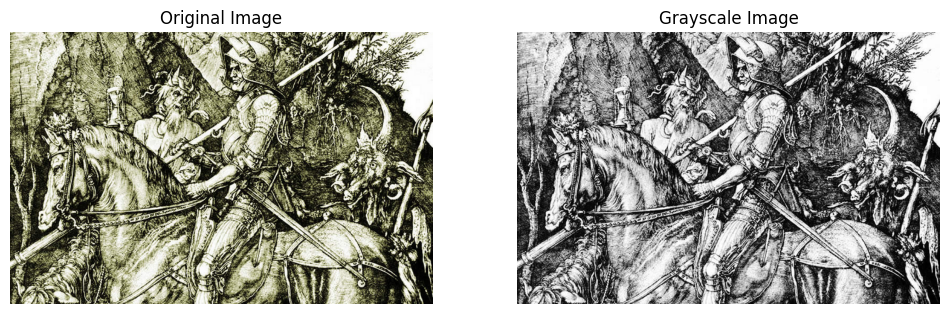

In [4]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_image_as_tensor(image_path):
    """Load an image and convert it to a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    return transform(image)

def show_images(original_tensor, grayscale_tensor):
    """Display the original and grayscale images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_tensor.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(grayscale_tensor.squeeze(), cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')

    plt.show()

def process_directory(directory_path, output_directory_base):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.png'):
                original_image_path = os.path.join(root, file)

                # Assuming grayscale images are saved in a mirrored directory structure
                relative_path = os.path.relpath(root, directory_path)
                grayscale_image_path = os.path.join(output_directory_base, relative_path, file)

                if os.path.exists(grayscale_image_path):  # Check if the grayscale image exists
                    # Load images as PyTorch tensors
                    original_tensor = load_image_as_tensor(original_image_path)
                    grayscale_tensor = load_image_as_tensor(grayscale_image_path)

                    # Show the images
                    show_images(original_tensor, grayscale_tensor)

                return  # Process only one image per directory

# Define the paths
directory_path = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\training_set'  # Update this path
output_directory_base = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\gray_training_set'  # Update this path

# Process one image from each directory
process_directory(directory_path, output_directory_base)

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_grayscale=None, transform_color=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform_grayscale: Transforms for grayscale images.
        transform_color: Transforms for color images.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform_grayscale)
        self.color_dataset = ImageFolder(color_dir, transform=transform_color)

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Transform for grayscale images (input)
transform_grayscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transform for color images (target)
transform_color = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\gray_training_set',
    color_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\training_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\gray_validation_set',
    color_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\validation_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)



In [7]:
import torch
from torch import nn

class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
class ColorizationVGG_16(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ColorizationVGG_16, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)
        # Additional upsampling to correct size
        self.upsample_layers = nn.Sequential(
           nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
        )

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.final_activation = nn.Tanh()

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        x = self.upsample_layers(conv8_3)
        final_out = self.final_conv(x)
        out_tanh = self.final_activation(final_out)
        # Adjust from [-1, 1] to [0, 1] if still needed
        out_adjusted = (out_tanh + 1) / 2
        return out_adjusted

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

model = ColorizationVGG_16().cuda()  # Initialize your model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Start with lr = 0.001

num_epochs = 85  # Total epochs: 10 with lr=0.001, 50 with lr=0.0001, 15 with lr=0.00001, and 10 with lr=0.000001
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    # Update learning rate according to the epoch
    if epoch == 5:  # After the first 5 epochs, change the LR to 0.0001
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001
        print("Learning rate changed to 0.00001.")
    elif epoch == 60:  # After 60 epochs, change the LR to 0.00001
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001
        print("Learning rate changed to 0.00001.")
    elif epoch == 75:  # After 75 epochs, change the LR to 0.000001
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.000001
        print("Learning rate changed to 0.000001.")

    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_loader = tqdm(training_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loader.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(training_loader)
    training_losses.append(avg_train_loss)
    print(f'\nEpoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')

    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    validation_loader_tqdm = tqdm(validation_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    with torch.no_grad():
        for inputs, targets in validation_loader_tqdm:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            validation_loss += loss.item()
            validation_loader_tqdm.set_postfix(loss=loss.item())

    avg_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(avg_validation_loss)
    print(f'\nEpoch {epoch+1}, Validation Loss: {avg_validation_loss:.4f}')

Epoch 1/70 [Training]:  69%|██████████████████████████████▏             | 331/483 [02:41<01:13,  2.08it/s, loss=0.0166]C:\Users\Zhengqi Wang\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/70 [Training]: 100%|█████████████████████████████████████████████| 483/483 [03:55<00:00,  2.05it/s, loss=0.012]



Epoch 1, Training Loss: 0.0234


Epoch 1/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.0228]



Epoch 1, Validation Loss: 0.0185


Epoch 2/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [04:02<00:00,  1.99it/s, loss=0.0156]



Epoch 2, Training Loss: 0.0157


Epoch 2/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:10<00:00,  5.17it/s, loss=0.0724]



Epoch 2, Validation Loss: 0.0636


Epoch 3/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:55<00:00,  2.05it/s, loss=0.0201]



Epoch 3, Training Loss: 0.0144


Epoch 3/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:10<00:00,  5.21it/s, loss=0.0417]



Epoch 3, Validation Loss: 0.0309


Epoch 4/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:54<00:00,  2.06it/s, loss=0.0162]



Epoch 4, Training Loss: 0.0138


Epoch 4/70 [Validation]: 100%|█████████████████████████████████████████████| 54/54 [00:10<00:00,  5.30it/s, loss=0.255]



Epoch 4, Validation Loss: 0.2296


Epoch 5/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:52<00:00,  2.08it/s, loss=0.0155]



Epoch 5, Training Loss: 0.0131


Epoch 5/70 [Validation]: 100%|█████████████████████████████████████████████| 54/54 [00:10<00:00,  5.28it/s, loss=0.154]



Epoch 5, Validation Loss: 0.1362


Epoch 6/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:51<00:00,  2.09it/s, loss=0.0155]



Epoch 6, Training Loss: 0.0130


Epoch 6/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:10<00:00,  5.26it/s, loss=0.0209]



Epoch 6, Validation Loss: 0.0229


Epoch 7/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:51<00:00,  2.09it/s, loss=0.0144]



Epoch 7, Training Loss: 0.0126


Epoch 7/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:10<00:00,  5.30it/s, loss=0.0262]



Epoch 7, Validation Loss: 0.0270


Epoch 8/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:44<00:00,  2.15it/s, loss=0.00754]



Epoch 8, Training Loss: 0.0115


Epoch 8/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.0195]



Epoch 8, Validation Loss: 0.0210


Epoch 9/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.0114]



Epoch 9, Training Loss: 0.0116


Epoch 9/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.0147]



Epoch 9, Validation Loss: 0.0130


Epoch 10/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:41<00:00,  2.19it/s, loss=0.0117]



Epoch 10, Training Loss: 0.0108


Epoch 10/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.131]



Epoch 10, Validation Loss: 0.1166


Epoch 11/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:41<00:00,  2.19it/s, loss=0.0118]



Epoch 11, Training Loss: 0.0108


Epoch 11/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:09<00:00,  5.50it/s, loss=0.016]



Epoch 11, Validation Loss: 0.0213


Epoch 12/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.012]



Epoch 12, Training Loss: 0.0105


Epoch 12/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0304]



Epoch 12, Validation Loss: 0.0384


Epoch 13/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00495]



Epoch 13, Training Loss: 0.0105


Epoch 13/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.00828]



Epoch 13, Validation Loss: 0.0126


Epoch 14/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.0113]



Epoch 14, Training Loss: 0.0099


Epoch 14/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.50it/s, loss=0.0184]



Epoch 14, Validation Loss: 0.0203


Epoch 15/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.0105]



Epoch 15, Training Loss: 0.0098


Epoch 15/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0183]



Epoch 15, Validation Loss: 0.0220


Epoch 16/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.015]



Epoch 16, Training Loss: 0.0094


Epoch 16/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.50it/s, loss=0.0143]



Epoch 16, Validation Loss: 0.0111


Epoch 17/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.00739]



Epoch 17, Training Loss: 0.0092


Epoch 17/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0247]



Epoch 17, Validation Loss: 0.0188


Epoch 18/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.0169]



Epoch 18, Training Loss: 0.0088


Epoch 18/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0068]



Epoch 18, Validation Loss: 0.0096


Epoch 19/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.00946]



Epoch 19, Training Loss: 0.0086


Epoch 19/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0248]



Epoch 19, Validation Loss: 0.0253


Epoch 20/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.0076]



Epoch 20, Training Loss: 0.0083


Epoch 20/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0153]



Epoch 20, Validation Loss: 0.0193


Epoch 21/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:48<00:00,  2.11it/s, loss=0.00703]



Epoch 21, Training Loss: 0.0083


Epoch 21/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:10<00:00,  5.29it/s, loss=0.0228]



Epoch 21, Validation Loss: 0.0227


Epoch 22/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:50<00:00,  2.09it/s, loss=0.0131]



Epoch 22, Training Loss: 0.0083


Epoch 22/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:10<00:00,  5.30it/s, loss=0.0306]



Epoch 22, Validation Loss: 0.0262


Epoch 23/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:49<00:00,  2.10it/s, loss=0.00704]



Epoch 23, Training Loss: 0.0079


Epoch 23/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.50it/s, loss=0.0119]



Epoch 23, Validation Loss: 0.0113


Epoch 24/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00886]



Epoch 24, Training Loss: 0.0078


Epoch 24/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.0068]



Epoch 24, Validation Loss: 0.0089


Epoch 25/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00557]



Epoch 25, Training Loss: 0.0076


Epoch 25/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00842]



Epoch 25, Validation Loss: 0.0113


Epoch 26/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00918]



Epoch 26, Training Loss: 0.0075


Epoch 26/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.00959]



Epoch 26, Validation Loss: 0.0114


Epoch 27/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.0106]



Epoch 27, Training Loss: 0.0073


Epoch 27/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0287]



Epoch 27, Validation Loss: 0.0308


Epoch 28/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00966]



Epoch 28, Training Loss: 0.0070


Epoch 28/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.0376]



Epoch 28, Validation Loss: 0.0417


Epoch 29/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00675]



Epoch 29, Training Loss: 0.0070


Epoch 29/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.00644]



Epoch 29, Validation Loss: 0.0084


Epoch 30/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00874]



Epoch 30, Training Loss: 0.0068


Epoch 30/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.107]



Epoch 30, Validation Loss: 0.0931


Epoch 31/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.0099]



Epoch 31, Training Loss: 0.0066


Epoch 31/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.42it/s, loss=0.0121]



Epoch 31, Validation Loss: 0.0107


Epoch 32/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00994]



Epoch 32, Training Loss: 0.0065


Epoch 32/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0135]



Epoch 32, Validation Loss: 0.0082


Epoch 33/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00889]



Epoch 33, Training Loss: 0.0064


Epoch 33/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.46it/s, loss=0.0112]



Epoch 33, Validation Loss: 0.0124


Epoch 34/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00655]



Epoch 34, Training Loss: 0.0063


Epoch 34/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.00795]



Epoch 34, Validation Loss: 0.0104


Epoch 35/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00692]



Epoch 35, Training Loss: 0.0061


Epoch 35/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.0128]



Epoch 35, Validation Loss: 0.0137


Epoch 36/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00552]



Epoch 36, Training Loss: 0.0060


Epoch 36/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.0481]



Epoch 36, Validation Loss: 0.0650


Epoch 37/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00445]



Epoch 37, Training Loss: 0.0059


Epoch 37/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.0216]



Epoch 37, Validation Loss: 0.0154


Epoch 38/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00744]



Epoch 38, Training Loss: 0.0059


Epoch 38/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.0189]



Epoch 38, Validation Loss: 0.0154


Epoch 39/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00702]



Epoch 39, Training Loss: 0.0057


Epoch 39/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.0508]



Epoch 39, Validation Loss: 0.0487


Epoch 40/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00675]



Epoch 40, Training Loss: 0.0057


Epoch 40/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.50it/s, loss=0.00845]



Epoch 40, Validation Loss: 0.0103


Epoch 41/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00655]



Epoch 41, Training Loss: 0.0056


Epoch 41/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.44it/s, loss=0.0256]



Epoch 41, Validation Loss: 0.0254


Epoch 42/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.0069]



Epoch 42, Training Loss: 0.0056


Epoch 42/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.033]



Epoch 42, Validation Loss: 0.0334


Epoch 43/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00536]



Epoch 43, Training Loss: 0.0055


Epoch 43/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.0412]



Epoch 43, Validation Loss: 0.0448


Epoch 44/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00497]



Epoch 44, Training Loss: 0.0053


Epoch 44/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0167]



Epoch 44, Validation Loss: 0.0172


Epoch 45/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00838]



Epoch 45, Training Loss: 0.0054


Epoch 45/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.46it/s, loss=0.0257]



Epoch 45, Validation Loss: 0.0294


Epoch 46/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00692]



Epoch 46, Training Loss: 0.0053


Epoch 46/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.46it/s, loss=0.0175]



Epoch 46, Validation Loss: 0.0181


Epoch 47/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00456]



Epoch 47, Training Loss: 0.0052


Epoch 47/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.0273]



Epoch 47, Validation Loss: 0.0302


Epoch 48/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00804]



Epoch 48, Training Loss: 0.0051


Epoch 48/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.0188]



Epoch 48, Validation Loss: 0.0183


Epoch 49/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00844]



Epoch 49, Training Loss: 0.0052


Epoch 49/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.49it/s, loss=0.0166]



Epoch 49, Validation Loss: 0.0185


Epoch 50/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00558]



Epoch 50, Training Loss: 0.0050


Epoch 50/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.0121]



Epoch 50, Validation Loss: 0.0122
Learning rate reduced to 0.00001.


Epoch 51/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00389]



Epoch 51, Training Loss: 0.0046


Epoch 51/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00452]



Epoch 51, Validation Loss: 0.0071


Epoch 52/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00496]



Epoch 52, Training Loss: 0.0045


Epoch 52/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.46it/s, loss=0.0106]



Epoch 52, Validation Loss: 0.0072


Epoch 53/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00421]



Epoch 53, Training Loss: 0.0045


Epoch 53/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.00906]



Epoch 53, Validation Loss: 0.0072


Epoch 54/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00547]



Epoch 54, Training Loss: 0.0045


Epoch 54/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00711]



Epoch 54, Validation Loss: 0.0071


Epoch 55/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00779]



Epoch 55, Training Loss: 0.0045


Epoch 55/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00707]



Epoch 55, Validation Loss: 0.0087


Epoch 56/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00421]



Epoch 56, Training Loss: 0.0044


Epoch 56/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.00863]



Epoch 56, Validation Loss: 0.0077


Epoch 57/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00411]



Epoch 57, Training Loss: 0.0044


Epoch 57/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.46it/s, loss=0.00869]



Epoch 57, Validation Loss: 0.0071


Epoch 58/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.006]



Epoch 58, Training Loss: 0.0044


Epoch 58/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.46it/s, loss=0.0059]



Epoch 58, Validation Loss: 0.0071


Epoch 59/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00529]



Epoch 59, Training Loss: 0.0044


Epoch 59/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.45it/s, loss=0.00915]



Epoch 59, Validation Loss: 0.0092


Epoch 60/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00417]



Epoch 60, Training Loss: 0.0044


Epoch 60/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00571]



Epoch 60, Validation Loss: 0.0072


Epoch 61/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00579]



Epoch 61, Training Loss: 0.0044


Epoch 61/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.44it/s, loss=0.00649]



Epoch 61, Validation Loss: 0.0070


Epoch 62/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00594]



Epoch 62, Training Loss: 0.0044


Epoch 62/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.43it/s, loss=0.00947]



Epoch 62, Validation Loss: 0.0079


Epoch 63/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00574]



Epoch 63, Training Loss: 0.0043


Epoch 63/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.48it/s, loss=0.0151]



Epoch 63, Validation Loss: 0.0084


Epoch 64/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00421]



Epoch 64, Training Loss: 0.0043


Epoch 64/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00567]



Epoch 64, Validation Loss: 0.0073


Epoch 65/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00628]



Epoch 65, Training Loss: 0.0043


Epoch 65/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00951]



Epoch 65, Validation Loss: 0.0073


Epoch 66/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00368]



Epoch 66, Training Loss: 0.0043


Epoch 66/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.46it/s, loss=0.00476]



Epoch 66, Validation Loss: 0.0071


Epoch 67/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00555]



Epoch 67, Training Loss: 0.0043


Epoch 67/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.45it/s, loss=0.0136]



Epoch 67, Validation Loss: 0.0127


Epoch 68/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.0045]



Epoch 68, Training Loss: 0.0043


Epoch 68/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.47it/s, loss=0.00949]



Epoch 68, Validation Loss: 0.0079


Epoch 69/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00421]



Epoch 69, Training Loss: 0.0043


Epoch 69/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.43it/s, loss=0.00548]



Epoch 69, Validation Loss: 0.0073


Epoch 70/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.0062]



Epoch 70, Training Loss: 0.0043


Epoch 70/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.45it/s, loss=0.00806]


Epoch 70, Validation Loss: 0.0073


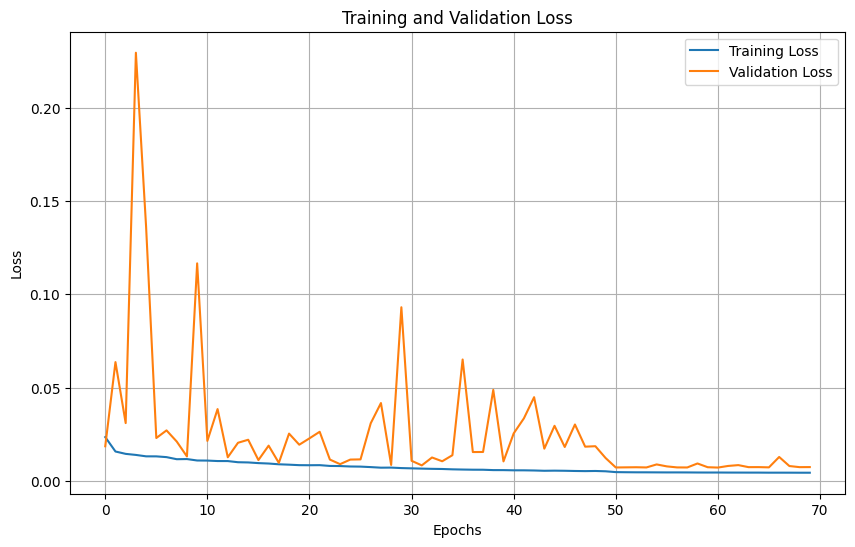

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

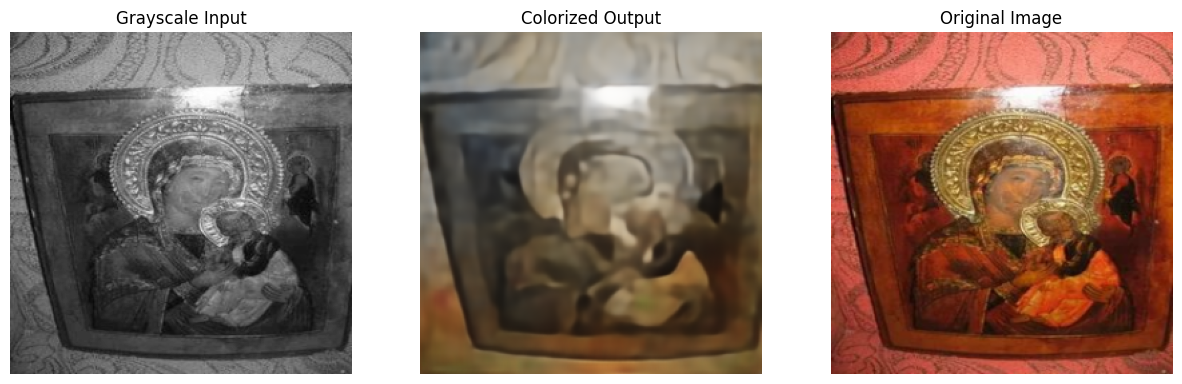

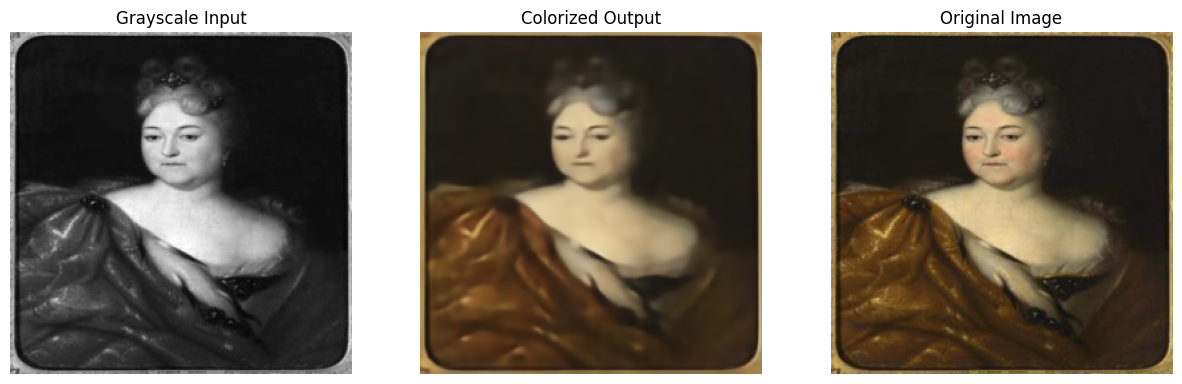

In [21]:
def visualize_results(grayscale, colorized, original):
    """
    Visualize grayscale input, colorized output, and the original color image.
    """
    with torch.no_grad():
        # Convert to numpy arrays
        grayscale = grayscale.cpu().numpy().transpose((1, 2, 0))
        colorized = colorized.cpu().numpy().transpose((1, 2, 0))
        original = original.cpu().numpy().transpose((1, 2, 0))

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(grayscale, cmap='gray')
        ax[0].set_title("Grayscale Input")
        ax[0].axis("off")

        ax[1].imshow(colorized)
        ax[1].set_title("Colorized Output")
        ax[1].axis("off")

        ax[2].imshow(original)
        ax[2].set_title("Original Image")
        ax[2].axis("off")

        plt.show()

# Assuming `model`, `validation_loader` are already defined and ready to use
model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[1], colorized_outputs[1], original_colors[1])
    visualize_results(grayscale_inputs[10], colorized_outputs[10], original_colors[10])

In [10]:
model_path = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\vgg-16_loss=MSE_batch16_lr=0.0001_on50_&lr=0.00001on20\model_state_dict.pth'
torch.save(model.state_dict(), model_path)

In [11]:
import csv

# Specify the path to the CSV file where you want to save the losses
csv_file_path = model_path+'losses.csv'

# Open the file in write mode
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])
    
    # Write the losses for each epoch
    for epoch in range(num_epochs):
        writer.writerow([epoch + 1, training_losses[epoch], validation_losses[epoch]])

print(f"Losses saved to {csv_file_path}")

Losses saved to C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\vgg-16_loss=MSE_batch16_lr=0.0001_on50_&lr=0.00001on20\model_state_dict.pthlosses.csv


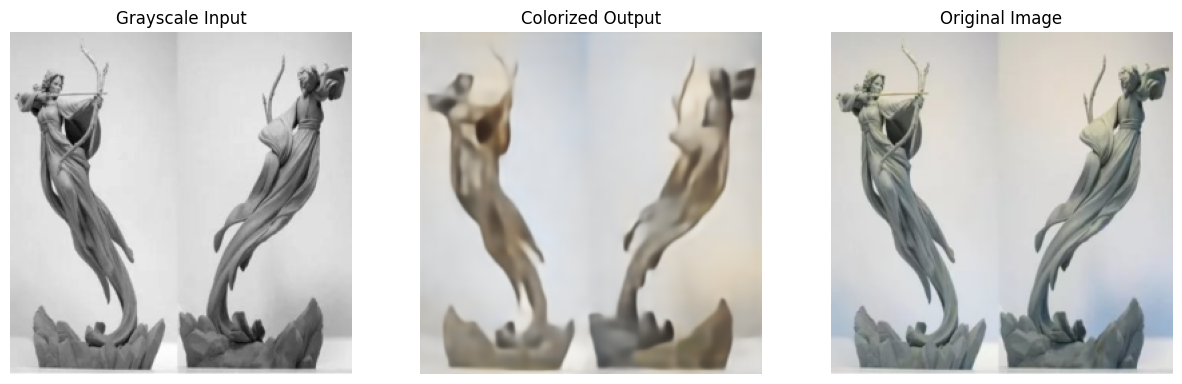

In [11]:
model_path = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\vgg-16_loss=MSE_batch16_lr=0.0001_on50_&lr=0.00001on20\model_state_dict.pth'
model = ColorizationVGG_16().cuda()  # Or just ECCVGenerator() if not using CUDA

# Load the weights back
model.load_state_dict(torch.load(model_path))

# Don't forget to call model.eval() if you're in inference mode
model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[5], colorized_outputs[5], original_colors[5])